In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import rasterio
from netCDF4 import Dataset

In [2]:
catch_path = os.path.join('..','data/raw/catchments')
polygons = gpd.read_file(os.path.join(catch_path,'regen_catchments_right.shp'))
polygons.head()

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry
0,2111140970,2111140930,2110008490,2110008490,2620.0,2620.0,174.3,174.4,22799308430,0,0,3,19896,"POLYGON ((12.89167 49.25000, 12.89202 49.25242..."
1,2111140930,2110448780,2110008490,2110008490,2612.4,2612.4,108.0,282.4,22799308420,0,0,3,19882,"POLYGON ((12.86250 49.24167, 12.85925 49.24243..."
2,2110449380,2111142630,2110008490,2110008490,2560.0,2560.0,120.2,120.3,22799308200,0,0,3,19769,"POLYGON ((12.40417 49.25833, 12.40328 49.25488..."
3,2111141680,2111142150,2110008490,2110008490,2580.7,2580.7,93.6,2117.8,22799308330,0,0,2,19814,"POLYGON ((12.55000 49.19167, 12.54668 49.19252..."
4,2110448780,2111141690,2110008490,2110008490,2596.9,2596.9,131.5,413.9,22799308410,0,0,3,19845,"POLYGON ((12.70833 49.31667, 12.70798 49.32742..."


In [3]:
polygons['catch_id_short'] = polygons['PFAF_ID'].apply(lambda row: int(str(row)[-4:]))

<Axes: >

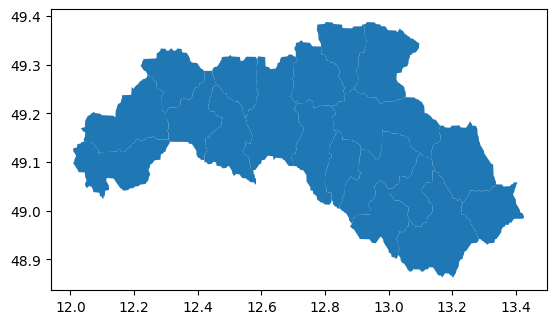

In [4]:
polygons.plot()

<Axes: >

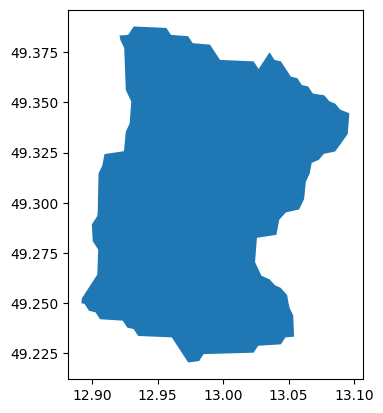

In [5]:
test = polygons[polygons['HYBAS_ID'] == 2111140970]
test.plot()

In [6]:
# test['geometry'].clip_by_rect(xmin = 12.5,xmax = 12.75,ymin =49.25,ymax = 49.5).plot()

In [7]:
meteo_dir = os.path.join('..','data','raw','meteo')
file_paths = [os.path.join(meteo_dir, f) for f in os.listdir(meteo_dir) if f.endswith(".nc")]
file_paths.sort()
datasets = [xr.open_dataset(file) for file in file_paths]
ds = xr.concat(datasets, dim="time")

# ds = xr.open_dataset(os.path.join('..',path,'2023_ERA5_Regen.nc'))

In [19]:
ds_daily = ds.resample(time="D").mean()
ds_daily

<xarray.Dataset> Size: 12MB
Dimensions:    (longitude: 9, latitude: 9, time: 3652)
Coordinates:
  * longitude  (longitude) float32 36B 12.0 12.25 12.5 12.75 ... 13.5 13.75 14.0
  * latitude   (latitude) float32 36B 50.0 49.75 49.5 49.25 ... 48.5 48.25 48.0
  * time       (time) datetime64[ns] 29kB 2014-01-01 2014-01-02 ... 2023-12-31
Data variables:
    d2m        (time, latitude, longitude) float64 2MB 270.9 270.9 ... 273.2
    t2m        (time, latitude, longitude) float64 2MB 271.8 271.6 ... 275.3
    ssr        (time, latitude, longitude) float64 2MB 6.091e+04 ... 1.609e+05
    sp         (time, latitude, longitude) float64 2MB 9.494e+04 ... 9.426e+04
    tp         (time, latitude, longitude) float64 2MB 5.146e-06 ... 0.0001246
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-30 22:36:29 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [43]:
ds_daily.sel(longitude = 12.5,latitude = 49.75, time = pd.to_datetime('2014-01-01'))

<xarray.Dataset> Size: 56B
Dimensions:    ()
Coordinates:
    longitude  float32 4B 12.5
    latitude   float32 4B 49.75
    time       datetime64[ns] 8B 2014-01-01
Data variables:
    d2m        float64 8B 270.3
    t2m        float64 8B 270.8
    ssr        float64 8B 8.312e+04
    sp         float64 8B 9.444e+04
    tp         float64 8B 2.329e-06
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-30 22:36:29 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [ ]:
ds_daily

In [9]:
# ds_daily = xr.Dataset({
#     'tp': ds['tp'].resample(time='D').mean(dim='time'),
#     'ssr': ds['ssr'].resample(time='D').mean(dim='time'),
#     'd2m': ds['d2m'].resample(time='D').mean(dim='time'),
#     't2m': ds['t2m'].resample(time='D').mean(dim='time'),
#     'sp': ds['sp'].resample(time='D').mean(dim='time')
# })
# ds_daily

In [78]:
#function to calculate the statistics for a catchment
def calc_zonal_stats(geom,catch_name,ds,time):
    #some weird geopandas things
    gdf = gpd.GeoDataFrame(geometry=[geom])
    geom = gdf['geometry']
    area = geom.area
    lon_list = np.arange(12,14,0.25)
    lat_list = np.arange(48,50,0.25)
    totals = np.empty(0)
    for var in list(ds.keys()):
        splits = np.empty(0)
        for lat in lat_list:
            for lon in lon_list:
                clip_area = geom.clip_by_rect(xmin = lon, xmax = lon + 0.25, ymin = lat, ymax = lat + 0.25).area.values[0]
                if clip_area == 0:
                    continue
                var_value = ds[var].sel(latitude=lat, longitude=lon,time = time, method='nearest',tolerance = 0.001).values
                splits = np.append(splits,(clip_area/area) * var_value)
        totals = np.append(totals,splits.sum())
    totals = np.append(totals,catch_name)
    return tuple(totals)


In [26]:
list(ds.keys())

['d2m', 't2m', 'ssr', 'sp', 'tp']

In [79]:
help_df = pd.DataFrame(columns=list(ds.keys())+['date','catch_name'])
help_df['d2m'],help_df['t2m'],help_df['ssr'],help_df['sp'],help_df['tp'], help_df['catch_name'] = zip(*polygons.apply(lambda row: calc_zonal_stats(geom = row['geometry'],catch_name=row['catch_id_short'],ds = ds_daily,time = '2023-01-01'),axis = 1))
help_df['date'] = pd.to_datetime('2023-01-01')
help_df


,d2m,t2m,ssr,sp,tp,date,catch_name
0,277.744912,281.874753,163547.213493,95781.682433,8.673617e-19,2023-01-01,8430.0
1,277.953683,281.965175,162815.749667,96245.832971,8.673617e-19,2023-01-01,8420.0
2,278.745883,281.968170,164812.546285,97118.749284,4.522911e-08,2023-01-01,8200.0
3,278.396319,281.414560,164609.092478,96893.999761,8.673617e-19,2023-01-01,8330.0
4,278.000594,281.402090,164433.853091,96388.502912,8.673617e-19,2023-01-01,8410.0
5,278.142240,280.701300,166507.085076,96916.955979,8.673617e-19,2023-01-01,8340.0
6,277.412039,280.469169,168332.043876,95467.488740,8.673617e-19,2023-01-01,8600.0
7,278.658705,282.126553,167577.999256,97063.080774,6.451933e-07,2023-01-01,8120.0
8,278.265001,280.872031,167644.489577,97050.763870,8.673617e-19,2023-01-01,8320.0
9,277.724625,280.366372,167997.578759,96277.920953,8.673617e-19,2023-01-01,8500.0


In [80]:
df_final = pd.DataFrame()
for t in ds_daily['time'].values:
    day = np.datetime64(t,'D')
    help_df = pd.DataFrame(columns=['tp','ssr','d2m','t2m','sp','date','catch_name'])
    help_df['tp'],help_df['ssr'],help_df['d2m'],help_df['t2m'],help_df['sp'],help_df['catch_name'] = zip(*polygons.apply(lambda row: calc_zonal_stats(geom = row['geometry'],catch_name=row['catch_id_short'],ds = ds_daily,time = t),axis = 1))
    help_df['date'] = day
    df_final = pd.concat((df_final,help_df),axis = 0)
    print(day)
df_final.reset_index(drop = True,inplace = True)

2014-01-01
2014-01-02
2014-01-03
2014-01-04
2014-01-05
2014-01-06
2014-01-07
2014-01-08
2014-01-09
2014-01-10
2014-01-11
2014-01-12
2014-01-13
2014-01-14
2014-01-15
2014-01-16
2014-01-17
2014-01-18
2014-01-19
2014-01-20
2014-01-21
2014-01-22
2014-01-23
2014-01-24
2014-01-25
2014-01-26
2014-01-27
2014-01-28
2014-01-29
2014-01-30
2014-01-31
2014-02-01
2014-02-02
2014-02-03
2014-02-04
2014-02-05
2014-02-06
2014-02-07
2014-02-08
2014-02-09
2014-02-10
2014-02-11
2014-02-12
2014-02-13
2014-02-14
2014-02-15
2014-02-16
2014-02-17
2014-02-18
2014-02-19
2014-02-20
2014-02-21
2014-02-22
2014-02-23
2014-02-24
2014-02-25
2014-02-26
2014-02-27
2014-02-28
2014-03-01
2014-03-02
2014-03-03
2014-03-04
2014-03-05
2014-03-06
2014-03-07
2014-03-08
2014-03-09
2014-03-10
2014-03-11
2014-03-12
2014-03-13
2014-03-14
2014-03-15
2014-03-16
2014-03-17
2014-03-18
2014-03-19
2014-03-20
2014-03-21
2014-03-22
2014-03-23
2014-03-24
2014-03-25
2014-03-26
2014-03-27
2014-03-28
2014-03-29
2014-03-30
2014-03-31
2014-04-01

In [81]:
df_final.columns = list(ds.keys())+['date','catch_name']
df_final

,d2m,t2m,ssr,sp,tp,date,catch_name
0,270.388360,271.163084,106039.867903,95026.575266,3.863650e-07,2014-01-01,8430.0
1,270.431175,271.223183,105646.034905,95510.019083,5.363124e-07,2014-01-01,8420.0
2,270.635909,271.096030,92893.417872,96408.998240,3.368777e-06,2014-01-01,8200.0
3,270.745759,271.282970,96308.181265,96170.012687,1.885016e-06,2014-01-01,8330.0
4,270.656135,271.308199,102042.046278,95646.550308,8.434484e-07,2014-01-01,8410.0
...,...,...,...,...,...,...,...
69383,274.140310,275.754280,126250.373400,94723.466563,7.551632e-05,2023-12-31,8711.0
69384,273.891666,275.456430,128911.086270,93972.148521,8.378309e-05,2023-12-31,8731.0
69385,273.743240,275.178920,132771.072153,93724.351911,8.758489e-05,2023-12-31,8800.0
69386,274.336695,275.921042,132179.580344,95942.309523,9.178094e-05,2023-12-31,8720.0


In [82]:
df_final['date'] = pd.to_datetime(df_final['date'])
pivot_df = df_final.pivot_table(index='date', columns='catch_name')
pivot_df.columns = [f'{measurement}_{str(station)[:4]}' for measurement, station in pivot_df.columns]
pivot_df.reset_index(inplace=True)
pivot_df

,date,d2m_8110,d2m_8120,d2m_8200,d2m_8310,d2m_8320,d2m_8330,d2m_8340,d2m_8410,d2m_8420,...,tp_8430,tp_8500,tp_8600,tp_8711,tp_8712,tp_8720,tp_8731,tp_8732,tp_8800,tp_8900
0,2014-01-01,270.572053,270.583782,270.635909,270.654055,270.739332,270.745759,270.809963,270.656135,270.431175,...,3.863650e-07,5.385893e-07,4.265803e-07,4.822628e-07,4.819734e-07,1.253954e-06,5.777455e-07,1.436822e-06,9.707704e-07,3.421187e-07
1,2014-01-02,272.099216,272.092494,272.033254,272.011163,271.930185,271.855601,271.828922,271.499671,271.303751,...,3.986104e-06,6.663734e-06,6.833090e-06,6.702358e-06,6.630144e-06,3.969168e-06,6.355495e-06,3.869216e-06,6.033745e-06,7.608540e-06
2,2014-01-03,273.586064,273.593394,273.661346,273.609307,273.617206,273.655408,273.638137,273.486784,273.461932,...,7.813191e-07,1.232235e-06,9.848191e-07,1.117973e-06,9.627160e-07,3.152130e-07,6.812810e-07,1.552123e-07,2.603002e-07,6.997454e-07
3,2014-01-04,275.260905,275.232914,275.151950,274.958773,274.731329,274.845612,274.597753,274.505045,274.514311,...,1.543407e-04,2.252660e-04,2.306176e-04,2.309710e-04,2.262798e-04,1.507445e-04,2.086118e-04,1.238402e-04,1.149645e-04,2.004822e-04
4,2014-01-05,275.990405,275.987339,275.925970,275.990665,275.978136,275.925076,275.947362,275.718691,275.591730,...,6.495372e-05,9.956195e-05,1.084148e-04,1.048100e-04,1.079762e-04,1.110781e-04,1.135130e-04,1.155993e-04,1.087480e-04,1.086862e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2023-12-27,276.840464,276.827041,276.563947,276.858344,276.854703,276.517919,276.707669,276.205850,275.969629,...,4.666478e-06,8.323537e-06,1.199765e-05,1.006777e-05,1.123335e-05,4.253323e-06,1.239131e-05,4.485424e-06,8.188290e-06,1.386781e-05
3648,2023-12-28,273.966011,274.003896,274.481394,274.004956,273.892577,274.268202,273.954371,273.939822,273.937324,...,4.349469e-06,8.525077e-06,7.186941e-06,7.983681e-06,7.407126e-06,8.299928e-06,6.351444e-06,6.934943e-06,4.598457e-06,5.399495e-06
3649,2023-12-29,277.561874,277.562894,277.562885,277.560730,277.507486,277.473328,277.449063,277.280038,277.254997,...,2.433315e-05,4.468264e-05,4.738118e-05,4.622679e-05,4.672316e-05,4.066719e-05,4.754517e-05,4.259339e-05,4.157456e-05,4.536385e-05
3650,2023-12-30,276.043015,276.051051,276.124256,276.084819,276.112852,276.164933,276.157221,276.094596,276.088948,...,2.499465e-05,2.077160e-05,3.040644e-05,2.498507e-05,2.828757e-05,8.883224e-06,3.148722e-05,9.169190e-06,2.475477e-05,3.975524e-05


In [83]:
pivot_df['ssr_8430']

0       106039.867903
1       110289.876906
2       146649.022020
3       122057.525817
4        35806.688368
            ...      
3647     89416.004554
3648    100287.000009
3649    131208.363394
3650    111942.588860
3651    118870.617190
Name: ssr_8430, Length: 3652, dtype: float64

In [84]:
pivot_df.to_pickle(os.path.join('..','data','processed','meteo_processed.pkl'),compression = 'zip')